In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

# import better_exceptions
from scikit_quri.qnn.regressor import QNNRegressor
import numpy as np
from numpy.random import default_rng

from quri_parts.core.operator import Operator, pauli_label
from quri_parts.core.estimator.gradient import (
    create_numerical_gradient_estimator)
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_concurrent_parametric_estimator,
    create_qulacs_vector_concurrent_estimator,
)
from quri_parts.algo.optimizer import Adam
from scikit_quri.circuit.pre_defined import create_qcl_ansatz

def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi * x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    # return np.array(x_train), np.array(y_train)
    return np.array(x_train).flatten(), np.array(y_train)

x_train,y_train = generate_noisy_sine(-1.,1.,80)
x_test,y_test = generate_noisy_sine(-1.,1.,80)

In [5]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
import matplotlib.pyplot as plt
n_qubits = 5
depth = 6
n_outputs = 1
parametric_circuit = create_qcl_ansatz(n_qubits,depth,0.5,0)

op = Operator()
for i in range(n_outputs):
    op.add_term(pauli_label(f"Z {i}"),1.0)
draw_circuit(parametric_circuit.circuit)

estimator = create_qulacs_vector_concurrent_estimator()
gradient_estimator = create_numerical_gradient_estimator(create_qulacs_vector_concurrent_parametric_estimator(),delta=1e-10)
adam = Adam()

   ___     ___     ___     ___     ___     ___     ___     ___     ___     ___  
  |PRY|   |PRZ|   |Mat|   |PRX|   |PRZ|   |PRX|   |Mat|   |PRX|   |PRZ|   |PRX| 
--|0  |---|1  |---|10 |---|11 |---|12 |---|13 |---|26 |---|27 |---|28 |---|29 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|2  |---|3  |---|   |---|14 |---|15 |---|16 |---|   |---|30 |---|31 |---|32 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|4  |---|5  |---|   |---|17 |---|18 |---|19 |---|   |---|33 |---|34 |---|35 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    _

In [6]:
init_params = 2*np.pi*np.random.rand(parametric_circuit.learning_params_count)

In [7]:
qnn = QNNRegressor(n_qubits,parametric_circuit,estimator,gradient_estimator,adam,op)

qnn.fit(x_train,y_train,maxiter=30)

init_params=array([1.46774986, 1.28828448, 1.39899023, 5.64748127, 1.45839158,
       3.96669308, 1.18548222, 0.92332396, 3.06188168, 3.1877129 ,
       4.06613981, 5.42225407, 2.01405839, 5.80886253, 1.21298981,
       2.31903451, 2.36369411, 0.84542679, 6.2086625 , 2.14165122,
       1.26714706, 2.63891739, 0.98833287, 1.50077018, 5.66210075,
       1.90587476, 1.52828967, 1.51100626, 1.3292733 , 5.22163139,
       4.5991069 , 0.14173203, 2.05832369, 0.96010719, 2.60972353,
       2.40837251, 4.9291523 , 4.88477829, 1.35739375, 1.05190944,
       2.82606557, 5.2728182 , 1.37343364, 3.32379675, 1.2015884 ,
       0.24400477, 4.569186  , 0.78549666, 0.36241415, 4.47838645,
       2.50547866, 1.33986908, 2.07555841, 0.77149509, 3.02220271,
       1.28492401, 0.67694652, 4.87709561, 4.31731012, 0.7607329 ,
       0.96821872, 1.53101332, 0.94456947, 0.52519633, 0.57010482,
       5.43604187, 5.63872116, 4.43563063, 4.22738192, 6.08139253,
       4.83792925, 5.27119237, 2.99371886, 2.26493

loss=0.005955010480647041


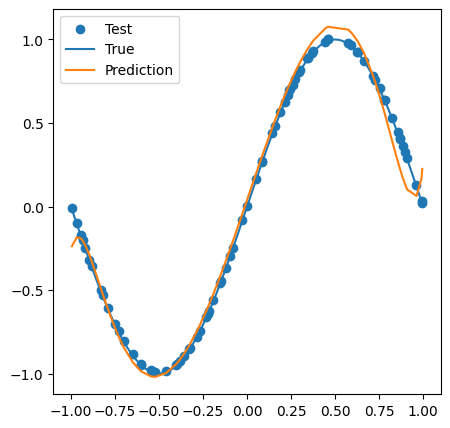

In [8]:
y_pred = qnn.predict(x_test)
y_test = y_test.reshape(-1,1)
plt.figure(figsize=(5,5))

plt.scatter(
    np.sort(x_test.flatten()),
    y_test[np.argsort(x_test.flatten())],label="Test")

x_true = np.linspace(-1,1,100)
y_true = np.sin(np.pi * x_true)
plt.plot(x_true,y_true,label="True")
plt.plot(
    np.sort(x_test.flatten()),
    y_pred[np.argsort(x_test.flatten())],
    label="Prediction")
plt.legend()

from sklearn.metrics import mean_squared_error
loss = mean_squared_error(y_test,y_pred)
print(f"{loss=}")
plt.show()